## Twitter Sentiment Analysis

This notebook is a streamlined version of the original model development workflow. It focuses solely on the essential steps required for model deployment: loading data, preprocessing, feature engineering, building the final model using the best hyperparameters, and saving the trained model. This simplified version addresses the limitation of the original notebook, which did not include model export for deployment purposes.

### 1. Import Libraries

In [7]:
# Data Manipulation Packages
import numpy as np
import pandas as pd

# Data Viz Packages
import matplotlib.pyplot as plt
import seaborn as sns

# NLP & Data Preprocessing Packages
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
from collections import Counter
import re
from imblearn.over_sampling import SMOTE

# Model Building Packages
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# Model Evaluation Packages
from sklearn.metrics import (
    confusion_matrix, classification_report, 
    accuracy_score, precision_score,  recall_score, f1_score,
    roc_auc_score, roc_curve, RocCurveDisplay, auc,
    precision_recall_curve, ConfusionMatrixDisplay
)
from sklearn import metrics

# Save Model
import os
import joblib

### 2. Import Dataset

In [8]:
# Load Twitter Dataset
df = pd.read_csv('Tweets.csv')

df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [9]:
# Drop columns that are not required for model building
df.drop(columns=['textID', 'selected_text'], inplace=True)

df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


### 3. Data Preprocessing

#### Checking for Missing Values

In [10]:
df.isnull().sum()

text         1
sentiment    0
dtype: int64

In [11]:
# Drop the record with missing values (Since there's only 1 record with missing value)
df.dropna(inplace=True)

df.isnull().sum()

text         0
sentiment    0
dtype: int64

#### Remove Duplicates and Retweets

In [12]:
# Check for Duplicates (No Duplicates Found)
df.duplicated().sum()

0

In [13]:
# Check for Retweets (No Retweets Found)
df['text'].str.startswith("RT").sum()

0

#### Label Grouping

In [14]:
# Combine positive and neutral sentiment into one class, i.e. non-negative
df['sentiment'] = df['sentiment'].replace({'neutral': 'non-negative', 'positive': 'non-negative'})

#### Emoticons Handling

In [15]:
# NOTE: Include for Deployment
# Define positive and negative emoticons
positive_emoticons = {":)", ":D", "XD", ":-)", "=)", ":-D", "(:", "(-:", ": D", ";D", ";-D", "(;", "(-;", "<3", "^-^", "^_^", "=D" }
negative_emoticons = {":(", ":-(", ":**-(", ":@", ":-@", ":\\", ":-\\", ":,(", ":'(" }

# Replace emoticons with sentiment labels
def replace_emoticons(text):
    for emo in positive_emoticons:
        text = re.sub(re.escape(emo), "emo_happy", text)
    for emo in negative_emoticons:
        text = re.sub(re.escape(emo), "emo_sad", text)
    return text

df['cleaned_text'] = df['text'].apply(replace_emoticons)

#### Normalize Text (Convert Text to Lowercase)

In [16]:
# NOTE: Include for Deployment
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

#### Conversion of Common Abbreviation

In [17]:
# NOTE: Include for Deployment
# Common abbreviations
abbreviation_dict = {
    "lol": "laughing out loud",
    "omg": "oh my god",
    "jk": "just kidding",
    "lmao": "laughing my ass off",
    "idk": "i don't know",
    "brb": "be right back",
    "btw": "by the way",
    "ttyl": "talk to you later",
    "imo": "in my opinion",
    "tbh": "to be honest",
    "u": "you",
    "tks": "thanks",
    "thnx": "thanks",
    "thks": "thanks"
}

# Function to replace abbreviations
def replace_abbreviations(text):
    words = text.split()
    words = [abbreviation_dict[word.lower()] if word.lower() in abbreviation_dict else word for word in words]
    return " ".join(words)

df['cleaned_text'] = df['cleaned_text'].apply(replace_abbreviations)

#### Reduction of Repetitive Letters

In [18]:
# NOTE: Include for Deployment
# Function to replace repetition of letters
def reduce_repeated_letters(text):
    return re.sub(r'(.)\1{2,}', r'\1\1', text)  # Replaces three or more consecutive same letters with two

df['cleaned_text'] = df['cleaned_text'].apply(reduce_repeated_letters)

#### Removing Noise (URL, Punctuations, Hashtags, Mentions, etc.)

In [19]:
# NOTE: Include for Deployment
# Function to remove noise
def remove_noise(text):
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@user)
    text = re.sub(r"#\w+", "", text)  # Remove hashtags (#topic)

    # Remove all punctuation except ! and ?
    punctuation_to_remove = string.punctuation.replace("!", "").replace("?", "")
    text = text.translate(str.maketrans('', '', punctuation_to_remove))

    text = re.sub(r'\.{2,}', '.', text)  # Replace multiple dots ".." or "..." with a single dot
    text = re.sub(r'\s+', ' ', text).strip()  # Replace multiple spaces with a single space
    return text

# Apply transformation and create 'cleaned_text' column
df['cleaned_text'] = df['cleaned_text'].apply(remove_noise)

#### Stopwords Removal

In [20]:
# NOTE: Include for Deployment
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) - {"not", "no", "never", "don't", "won't", "isn't", "wasn't", "but", "although", "why", "how", "what", "who", "where", "when"}

def remove_stopword(text):
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

df['cleaned_text'] = df['cleaned_text'].apply(remove_stopword)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WeiZhenLim\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Tokenization and Stemming

In [21]:
# Simple Tokenization (Using .split())
df['tokens'] = df['cleaned_text'].apply(lambda x: x.split())

# Stemming on tokenized words
stemmer = PorterStemmer()
df['stemmed_tokens'] = df['tokens'].apply(lambda x: [stemmer.stem(word) for word in x])

# Convert stemmed tokens back to text (for TF-IDF/Vectorization)
df['stemmed_text'] = df['stemmed_tokens'].apply(lambda x: " ".join(x))

#### Export preprocessed data for EDA in Streamlit

In [22]:
df.head()

,text,sentiment,cleaned_text,tokens,stemmed_tokens,stemmed_text
0,"I`d have responded, if I were going",non-negative,id responded going,"[id, responded, going]","[id, respond, go]",id respond go
1,Sooo SAD I will miss you here in San Diego!!!,negative,soo sad miss san diego!!,"[soo, sad, miss, san, diego!!]","[soo, sad, miss, san, diego!!]",soo sad miss san diego!!
2,my boss is bullying me...,negative,boss bullying,"[boss, bullying]","[boss, bulli]",boss bulli
3,what interview! leave me alone,negative,what interview! leave alone,"[what, interview!, leave, alone]","[what, interview!, leav, alon]",what interview! leav alon
4,"Sons of ****, why couldn`t they put them on t...",negative,sons why couldnt put releases already bought,"[sons, why, couldnt, put, releases, already, b...","[son, whi, couldnt, put, releas, alreadi, bought]",son whi couldnt put releas alreadi bought


In [23]:
df.shape

(27480, 6)

In [24]:
from pathlib import Path

# Save directly to your home directory
filepath = Path.home() / "Preprocessed_Tweets.csv"
df.to_csv(filepath, index=False)

print(f"Saved to: {filepath}")

Saved to: C:\Users\WeiZhenLim\Preprocessed_Tweets.csv


### 4. Model Building

#### Train-test Data Split

In [25]:
# 80% Train, 20% Test
X_train, X_test, y_train, y_test = train_test_split(df['stemmed_text'], df['sentiment'], test_size=0.2, random_state=36)

print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

X_train Shape: (21984,)
X_test Shape: (5496,)
y_train Shape: (21984,)
y_test Shape: (5496,)


#### Label Encoding

In [26]:
# Manually map labels
y_train_encoded = y_train.map({'negative': 1, 'non-negative': 0})
y_test_encoded = y_test.map({'negative': 1, 'non-negative': 0})

In [27]:
print(y_train_encoded.head())

print(y_test_encoded.head())

16816    1
23601    0
913      1
12697    1
9797     0
Name: sentiment, dtype: int64
22005    0
4834     0
6675     0
16457    0
11978    0
Name: sentiment, dtype: int64


#### TF-IDF Vectorization

In [28]:
vectorizer = TfidfVectorizer(ngram_range=(1,2))  # Use both unigrams and bigrams

# Fit TF-IDF on training data and transform both train and test sets
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)  # Transform test data (NO fitting to avoid data leakage)

In [29]:
# Save directly to your home directory
filepath_1 = Path.home() / "20250322_TFIDFVectorizer.pkl"

joblib.dump(vectorizer, filepath_1)

print(f"Saved to: {filepath_1}")

Saved to: C:\Users\WeiZhenLim\20250322_TFIDFVectorizer.pkl


#### Class Balancing (SMOTE)

In [23]:
# Use SMOTE technique to perform class balancing
smote = SMOTE(random_state=36)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_vec, y_train_encoded)

print('Before balanced: ', Counter(y_train_encoded))

print('After balanced: ', Counter(y_train_balanced))

Before balanced:  Counter({0: 15765, 1: 6219})
After balanced:  Counter({1: 15765, 0: 15765})


#### Functions for Model Evaluation

In [24]:
def Classification_Summary(y_test, pred, pred_prob):
    
    print('Accuracy = {}%'.format(round(accuracy_score(y_test, pred), 3) * 100))
    print('F1 Score = {}%'.format(round(f1_score(y_test, pred, average='weighted'), 3) * 100))
    print('\n\033[1mConfusion Matrix:\033[0m\n', confusion_matrix(y_test, pred))
    print('\n\033[1mClassification Report:\033[0m\n', classification_report(y_test, pred))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, pred_prob)
    auc_score = roc_auc_score(y_test, pred_prob)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label="ROC Curve (AUC = {:.2f})".format(auc_score))
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier baseline
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

def Confusion_Matrix(y_test, pred):
    # Confusion matrix for testing data
    conf_mat_test = confusion_matrix(y_test, pred)

    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    # Test data (count)
    sns.heatmap(conf_mat_test, square=True, annot=True, cmap='Blues', fmt='d', cbar=False, ax=axes[0])
    axes[0].set_title('Confusion Matrix (Test)', fontsize=10, fontweight='bold')
    axes[0].set_ylabel('Actual', fontsize=10)
    axes[0].set_xlabel('Predicted', fontsize=10)

    # Test data (percentage)
    conf_mat_percentage = conf_mat_test / conf_mat_test.sum(axis=1, keepdims=True)  # Normalize by row
    sns.heatmap(conf_mat_percentage, square=True, annot=True, cmap='Blues', fmt='.2%', cbar=False, ax=axes[1])
    axes[1].set_title('Confusion Matrix (Percentage)', fontsize=10, fontweight='bold')
    axes[1].set_ylabel('Actual', fontsize=10)
    axes[1].set_xlabel('Predicted', fontsize=10)

    plt.tight_layout()
    plt.show()

#### XGBoost (XGB) Model

In [25]:
# Define parameter grid with finer granularity
param_dist = {
    'n_estimators': np.arange(200, 600, 50),
    'max_depth': np.arange(3, 12),
    'min_child_weight': np.arange(1, 15),
    'gamma': np.linspace(0, 5, 15),
    'learning_rate': np.linspace(0.01, 0.3, 15),
    'subsample': np.linspace(0.6, 1, 8),
    'colsample_bytree': np.linspace(0.6, 1, 8),
    'reg_alpha': np.linspace(0, 1, 5),
    'reg_lambda': np.linspace(1, 10, 5)
}

# Use Stratified Cross-Validation to ensure class balance in folds
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=36)

# Initialize XGBoost model
xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=36)

# Randomized search with more iterations
random_search = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=50, scoring='f1', cv=cv, n_jobs=-1, verbose=1, random_state=42
)

# Train model with hyperparameter tuning
random_search.fit(X_train_balanced, y_train_balanced)

# Get best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Train the best model
best_xgb = XGBClassifier(**best_params, objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=36)
best_xgb.fit(X_train_balanced, y_train_balanced)


Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:41:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'subsample': 0.6571428571428571, 'reg_lambda': 7.75, 'reg_alpha': 0.25, 'n_estimators': 450, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.1757142857142857, 'gamma': 1.7857142857142858, 'colsample_bytree': 0.6571428571428571}


C:\Users\WeiZhenLim\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [00:42:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6571428571428571, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.7857142857142858, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1757142857142857,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=450, n_jobs=None,
              num_parallel_tree=None, ...)

Optimal Threshold: 0.35318336
Accuracy = 82.1%
F1 Score = 82.1%

Confusion Matrix:
 [[3436  498]
 [ 488 1074]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3934
           1       0.68      0.69      0.69      1562

    accuracy                           0.82      5496
   macro avg       0.78      0.78      0.78      5496
weighted avg       0.82      0.82      0.82      5496



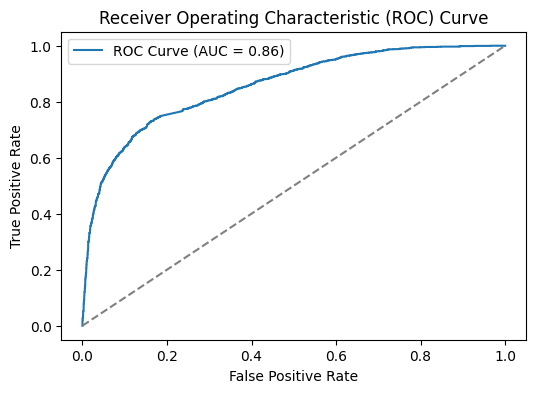

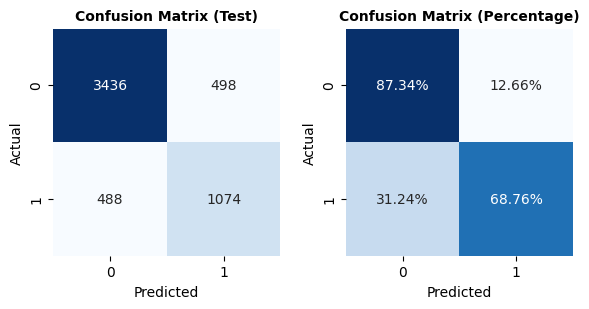

In [27]:
xgb_stemmed_tuned_prob = best_xgb.predict_proba(X_test_vec)[:, 1] # Probability

# Optimize threshold to improve F1-score for class 1

precisions, recalls, thresholds = precision_recall_curve(y_test_encoded, xgb_stemmed_tuned_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold:", optimal_threshold)

# Apply new threshold
xgb_stemmed_tuned_pred = (xgb_stemmed_tuned_prob >= optimal_threshold).astype(int) # Predictions

# Evaluate Performance
Classification_Summary(y_test_encoded, xgb_stemmed_tuned_pred, xgb_stemmed_tuned_prob)
Confusion_Matrix(y_test_encoded, xgb_stemmed_tuned_pred)

#### Save Model

In [ ]:
# Save directly to your home directory
filepath_2 = Path.home() / "20250322_Tuned_XGBoost_Model.pkl"

joblib.dump(best_xgb, filepath_2)

print(f"Saved to: {filepath_2}")

Saved to: C:\Users\WeiZhenLim\20250322_Tuned_XGBoost_Model.pkl
